In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Flatten, Dense
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from glob import glob
import matplotlib.pyplot as plt

In [2]:
#based on https://www.kaggle.com/code/pankul/image-classification-w-vgg16-weights
IMAGE_SIZE = [100, 100]  
batch_size = 64
nb_epochs = 10
train_data_dir = '../input/fruits/fruits-360_dataset/fruits-360/Training'
test_data_dir = '../input/fruits/fruits-360_dataset/fruits-360/Test'

# getting the number of classes i.e. type of fruits
folders = glob(train_data_dir + '/*')
num_classes = len(folders)
print ('Total Classes = ' + str(num_classes))

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  image_size=IMAGE_SIZE,
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  image_size=IMAGE_SIZE,
  batch_size=batch_size)

datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_directory(train_data_dir, target_size = IMAGE_SIZE, batch_size = batch_size, class_mode = 'categorical')
test_gen = datagen.flow_from_directory(test_data_dir, target_size = IMAGE_SIZE, batch_size = batch_size, class_mode = 'categorical')

Total Classes = 131
Found 67692 files belonging to 131 classes.


2022-12-04 20:55:37.560565: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 20:55:37.561644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 20:55:37.846891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 20:55:37.847752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 20:55:37.848557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Found 22688 files belonging to 131 classes.
Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [3]:
# loading the weights of VGG16 without the top layer. These weights are trained on Imagenet dataset.
vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)

# this will exclude the initial layers from training phase as there are already been trained.
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(1024, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(num_classes, activation = 'softmax')(x)
model = Model(inputs = vgg.input, outputs = x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

58900480/58889256 [==============================] - 0s 0us/step


In [4]:
earlystop = EarlyStopping(
    monitor='val_acc',
    min_delta=0.005,
    patience=5,
    verbose=1,
)

In [5]:
history = model.fit(train_gen,  
                   epochs = 30,  
                   validation_data = test_gen,
                   callbacks=[earlystop,]) 

2022-12-04 20:55:52.243396: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-12-04 20:55:55.212543: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1058/1058 [==============================] - 619s 572ms/step - loss: 0.3102 - acc: 0.9332 - val_loss: 0.3338 - val_acc: 0.9165
Epoch 2/30
1058/1058 [==============================] - 184s 174ms/step - loss: 0.0294 - acc: 0.9926 - val_loss: 0.1923 - val_acc: 0.9514
Epoch 3/30
1058/1058 [==============================] - 183s 173ms/step - loss: 0.0282 - acc: 0.9921 - val_loss: 0.3150 - val_acc: 0.9294
Epoch 4/30
1058/1058 [==============================] - 183s 172ms/step - loss: 0.0230 - acc: 0.9933 - val_loss: 0.6527 - val_acc: 0.8954
Epoch 5/30
1058/1058 [==============================] - 182s 172ms/step - loss: 0.0171 - acc: 0.9952 - val_loss: 0.3759 - val_acc: 0.9252
Epoch 6/30
1058/1058 [==============================] - 183s 173ms/step - loss: 0.0050 - acc: 0.9988 - val_loss: 0.1790 - val_acc: 0.9680
Epoch 7/30
1058/1058 [==============================] - 181s 171ms/step - loss: 1.6978e-05 - acc: 1.0000 - val_loss: 0.1837 - val_acc: 0.9666
Epoch 8/30
1058/1058 [===================

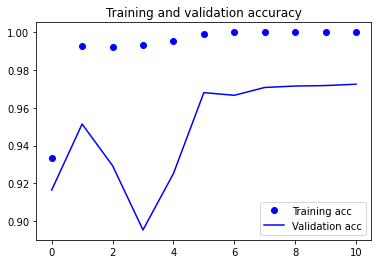

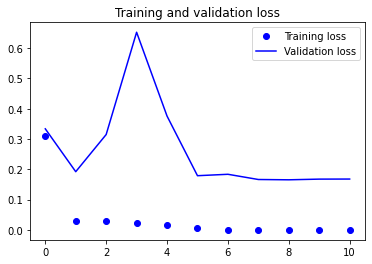

In [6]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()